Xiangyu Wei, Haimei Yu 
<br/>
A14528718, A15255117
<br/>
COGS 118C - final project
<br/>
dataset choice: human dataset 
<br/>
code address: https://github.com/yuhaimei/COGS__118C_Final_Project/blob/master/human%20analysis%20.ipynb

# Exploring Correlation of ECoG Signals During Movement of Different Fingers

## Abstract 
In this project, we explored the human dataset adapted from Miller et al., JNeuro, 2007 and curated by Richard Gao. We applied methods we learned from COGS 118C, including Fourier Transform, Spectrogram with STFT, Filter, theta-gamma coupling, PCA dimensionality reduction, correlation, and ECoG averaging. We found that coupling between theta and gamma existed (although weakly) in brain signals from this dataset. We also found that the correlation between brain signals and finger flexion was different for each fingers. Additionally, the correlation between brain signals of each finger within different channels during finger movement was different from each other, and the closer the fingers were, the more correlated their corresponding brain signals were. 

## Introduction
People always want to know how the brain works and how it can control the whole body. Correlation between human brain signals and body movement have been studies over decades. In 2012, Liang and Bougrain suggested finger flexion can be predicted from ECoG signals in humans. In 2014, Liao and his collegues proposed that they were able to discriminate which finger had moved from EEG data with their machine learning techniques, such as PCA analysis. EEG has poorer spatial resolution than ECoG, but in their experiment, they used around 60 EEG channels for each subject, and those channels were located spreading more than half of the cortex surface so that they were able to discriminate the movement of different fingers. In our project, we tried to analyze the ECoG dataset recorded from human participants doing finger movement task. Although we only had three channels of signals, they were recorded inside scalp. This dataset should give us much finer spatial resolution than EEG. So we expected to see similar relationship between brain and finger data as previous research. Although we did not have enough machine learning techniques to identify the fingers as what previous research did, we wanted to at least find what the relationships were between brain signals during the movement of different fingers and see if they are consistent with previous research. We would also like to find the relationship between brain and actual finger flexions. 
### - Research Question 
Are the relationship between brain and finger consistent with previous research? 
    <br>
To be more specific, will there be different correlation value between brain signals (from three channels) and the flexion recorded from different fingers? Will correlation between brain signals measured during different fingers' movement has consistent difference? (Will ECoG recorded only from three nearby locations be able to show us the discrimination of brain signals during movement of different fingers?) 
### - Hypothesis 
We hypothesized that we would see different correlation coefficient value between brain signals and the flexion recorded from different fingers. We also hypothesized that there might be some consistent difference between the correlation magnitude of brain signals measured during different finger movement would be different. (Since some of the electrodes might be closer to the brain area corresponding to one  and some might be closer for another one.)

## Material  
We will be using following python packages to analyze our data. The data set we will be using is the third choice-human dataset. This dataset was obtained from Miller et al., JNeuro, 2007 and curated by Instructor Richard Gao. The original experiment instructed participants to move their fingers according to cues “0,1,2,3,4,5” while each number corresponded to one finger, and “0” corresponded to rest. This Data resource included the sequences of cues, actual response of which finger was moved, actual flexion of fingers and ECoG data of three channels at dorsal M1, dorsal M1, and dorsal S1 through the experiment.  

Now, we are going to import packages and the dataset. 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
from scipy import io, signal
from scipy.cluster.vq import whiten
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from numpy.polynomial.polynomial import polyfit

In [2]:
#inport human eeg data
human_ecog_data = io.loadmat('ECoG_human/ECoG_human.mat', squeeze_me = True)

We built some help functions for future analysis, and they were all stored in this following cell.

In [3]:
#function for filter 
def apply_filter(cutoff,pass_zero,signal_1,signal_2,signal_3):
    filt_order = int(3*fs/cutoff[0])+1
    if (filt_order %2 == 0) and (pass_zero == True):
        filt_order = int(3*fs/cutoff[0])
    else:
        filt_order = int(3*fs/cutoff[0])+1
    filt_coef = signal.firwin(filt_order, cutoff, fs=fs, pass_zero=pass_zero)
    filtered_1 = np.convolve(signal_1, filt_coef, mode='same')
    filtered_2 = np.convolve(signal_2, filt_coef, mode='same')
    filtered_3 = np.convolve(signal_3, filt_coef, mode='same')
    return filtered_1,filtered_2,filtered_3

#function which apply fourier transform to brain signals from three channels. 
def apply_fourier(filtered_1,filtered_2,filtered_3):
    F_fft_1 = np.fft.fft(filtered_1) 
    F_fft_2 = np.fft.fft(filtered_2)
    F_fft_3 = np.fft.fft(filtered_3)
    return F_fft_1, F_fft_2, F_fft_3

#function that makes that power spectrum 
def make_power_spectrum(signal_1,signal_2,signal_3):
    np_power_1_filtered = np.abs(signal_1)**2
    np_power_2_filtered = np.abs(signal_2)**2
    np_power_3_filtered = np.abs(signal_3)**2
    plt.loglog(freqs, np_power_1_filtered, alpha=0.5, label=human_ecog_data['labels'][0])
    plt.loglog(freqs, np_power_2_filtered,  alpha=0.5, label=human_ecog_data['labels'][1])
    plt.loglog(freqs, np_power_3_filtered, alpha=0.5, label=human_ecog_data['labels'][2])
    plt.xlabel('log frequency(Hz)')
    plt.ylabel('log power(squared)')
    plt.xlim([0.0001,100]) #since log cannot be equal to 0, we set the left limit to be 0.0001, approaching 0.
    plt.legend()
    return

#function which plots spectrogram 
def plot_spectrogram(spg, t, f, freq_lims=[0,100], plot_db=False):
    plt.figure(figsize=(15,4))
    if plot_db:
        plt.imshow(10*np.log10(spg), aspect='auto', extent=[t[0], t[-1], f[-1], f[0]])
    else:
        plt.imshow(spg, aspect='auto', extent=[t[0], t[-1], f[-1], f[0]])
    plt.xlabel('Time(seconds)'); plt.ylabel('Frequency(Hz)');
    plt.ylim(freq_lims)
    plt.colorbar()
    plt.tight_layout()
    
#funnction computing power and phase 
def compute_power_phase(x_a):
    pw = np.abs(x_a)**2
    phase = np.angle(x_a)
    return pw, phase

#function for plotting different finger theta & gamma coupling (distribution)
def make_finger_plot_1(brain_signal):
    FIR_gamma = signal.firwin(int(3*fs/30) -1, [30,50], fs=fs, pass_zero=False)
    gamma_osc = np.convolve(brain_signal, FIR_gamma, mode='same') 
    x_a_gamma = signal.hilbert(gamma_osc)
    gamma_power, gamma_phase = compute_power_phase(x_a_gamma)

    FIR_theta = signal.firwin(int(3*fs/4) -1, [4,10], fs=fs, pass_zero=False)
    theta_osc = np.convolve(brain_signal, FIR_theta, mode='same')
    x_a_theta= signal.hilbert(theta_osc)
    theta_power, theta_phase = compute_power_phase(x_a_theta)
    
    peak_inds= np.where(np.logical_and(theta_phase>-np.pi/2, theta_phase<np.pi/2))[0]
    trough_inds = np.where(np.logical_or(theta_phase<-np.pi/2, theta_phase>np.pi/2))[0]

    plt.hist(np.abs(x_a_gamma)[peak_inds], 100, color='k', histtype='step', label='Peak');
    plt.hist(np.abs(x_a_gamma)[trough_inds],100, color='r', histtype='step', label='Trough');
    plt.xlabel('gamma amplitude')
    plt.ylabel('number')
    plt.legend()

#function for plotting different finger theta & gamma coupling (theta phase vs. gamma amplitude)
def make_finger_plot_2(brain_signal):
    FIR_gamma = signal.firwin(int(3*fs/30) -1, [30,50], fs=fs, pass_zero=False)
    gamma_osc = np.convolve(brain_signal, FIR_gamma, mode='same') 
    x_a_gamma = signal.hilbert(gamma_osc)
    gamma_power, gamma_phase = compute_power_phase(x_a_gamma)

    FIR_theta = signal.firwin(int(3*fs/4) -1, [4,10], fs=fs, pass_zero=False)
    theta_osc = np.convolve(brain_signal, FIR_theta, mode='same')
    x_a_theta= signal.hilbert(theta_osc)
    theta_power, theta_phase = compute_power_phase(x_a_theta)
    
    peak_inds= np.where(np.logical_and(theta_phase>-np.pi/2, theta_phase<np.pi/2))[0]
    trough_inds = np.where(np.logical_or(theta_phase<-np.pi/2, theta_phase>np.pi/2))[0]
    
    plt.plot(theta_phase,2*np.abs(x_a_gamma),'.');
    plt.xlabel('theta phase')
    plt.ylabel('gamma amplitude')
    return

# function for the regression plot
def regression_plot(df, x_name, y_name):
    # data ready
    x = df[x_name]
    y = df[y_name]
    intercept, slope = polyfit(x, y, 1)
    
    # plot the regression
    plt.plot(x, y, '.', alpha=0.5)
    plt.plot(x, intercept + slope * x, '-', c='orange', linewidth=3.0)
    plt.xlabel(x_name)
    plt.ylabel(y_name)

# function for creating correlation matrix
def corr_matrix(df):
    corr = df.corr()
    print(corr)
    ax = plt.axes()
    sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='Spectral', ax=ax)
    return

# function to compute PCA
def pca_fit(df, name1, name2, name3=None):

    # pull out required data
    dm1 = df[name1]
    dm2 = df[name2]
    if name3 != None:
        dm3 = df[name3]

    # initialize PCA object
    pca = PCA(n_components=1, whiten=True)
    
    if name3 != None:
        # combine data
        pca_data = np.array([dm1, dm2, dm3]).T

        # fit the dimensionality reduction model
        pca_fit = pca.fit_transform(pca_data)
    else:
        # combine data
        pca_data = np.array([dm1, dm2]).T

        # fit the dimensionality reduction model
        pca_fit = pca.fit_transform(pca_data)

    # plot the data
    t = np.arange(0, len(dm1)/fs, 1/fs)
    plt.figure(figsize=(15,3))
    plt.plot(t, pca_fit, '-')
    plt.xlabel('Time (s)')
    plt.ylabel('PCA')
    plt.xlim([0,100])
    
    return pca_fit

# function to get start & end index
def get_ind(signal, responses, finger):
    # initilize empty result list
    start_ind = []
    
    # loop thourgh response and check finger
    for ind in np.arange(len(responses)):
        if responses[ind] == finger:
            # get the start index
            if ind != 0 and responses[ind - 1] != responses[ind]:
                start_ind.append(ind)
            
    return start_ind

# function to get the window
def get_window(signal, responses, finger):
    # get start index & end index
    start_ind = get_ind(signal, responses, finger) 
    win_lst = []
    # loop through all indices
    for start in start_ind:
        # get window
        pre = start
        post = start + 6000
        if pre >= 0 and post <= len(signal):
            # grab window
            window = signal[pre: post]
            # append epoch to list
            win_lst.append(window)    
    # convert list to array
    all_wins = np.array(win_lst)   
    return all_wins

# function to get random window
def random_win(signal, responses, finger):
    random_ind = np.random.randint(0, len(signal), size=100)
    win_lst = []
    # loop through all indices
    for start in random_ind:
        # get window
        pre = start
        post = start + 6000
        if pre >= 0 and post <= len(signal):
            # grab window
            window = signal[pre: post]
            # append epoch to list
            win_lst.append(window)
    # convert list to array
    all_wins = np.array(win_lst) 
    return all_wins

# function to get fingers EEG
def get_EEG(finger):
    # get EEG for all area
    finger_EEG1 = get_window(area_1, response, finger)
    finger_EEG1A = np.mean(finger_EEG1,axis=0)
    finger_EEG2 = get_window(area_2, response, finger)
    finger_EEG2A = np.mean(finger_EEG2,axis=0)
    finger_EEG3 = get_window(area_3, response, finger)
    finger_EEG3A = np.mean(finger_EEG3,axis=0)
    finger_EEG = get_window(dim_red_total[:,0], response, finger)
    finger_EEGA = np.mean(finger_EEG,axis=0)    
    return finger_EEG1A, finger_EEG2A, finger_EEG3A, finger_EEGA

# function to plot EEG and average EEG
def plot_EEG(finger, func):
    # get EEG for all area
    finger_EEG1 = func(area_1, response, finger)
    finger_EEG1A = np.mean(finger_EEG1,axis=0)
    finger_EEG2 = func(area_2, response, finger)
    finger_EEG2A = np.mean(finger_EEG2,axis=0)
    finger_EEG3 = func(area_3, response, finger)
    finger_EEG3A = np.mean(finger_EEG3,axis=0)
    finger_EEG = func(dim_red_total[:,0], response, finger)
    finger_EEGA = np.mean(finger_EEG,axis=0)
    t_epoch = np.arange(0, 6, 1/fs) 
    # plot all the epochs and average
    plt.figure(figsize=(20,6))
    plt.subplot(1, 4, 1)
    plt.plot(t_epoch, finger_EEG1.T, '-k', alpha=0.02)
    plt.plot(t_epoch, finger_EEG1A, label='Average Response')
    plt.xlabel('Time (s)')
    plt.ylabel('Finger ' + str(finger), fontsize = 25)
    plt.title('Dorsal M1a')
    plt.legend()
    
    plt.subplot(1, 4, 2)
    plt.plot(t_epoch, finger_EEG2.T, '-k', alpha=0.02)
    plt.plot(t_epoch, finger_EEG2A, label='Average Response')
    plt.xlabel('Time (s)')
    plt.title('Dorsal M1b')
    plt.legend()
    
    plt.subplot(1, 4, 3)
    plt.plot(t_epoch, finger_EEG3.T, '-k', alpha=0.02)
    plt.plot(t_epoch, finger_EEG3A, label='Average Response')
    plt.xlabel('Time (s)')
    plt.title('Dorsal S1')
    plt.legend()
    
    plt.subplot(1, 4, 4)
    plt.plot(t_epoch, finger_EEG.T, '-k', alpha=0.02)
    plt.plot(t_epoch, finger_EEGA, label='Average Response')
    plt.xlabel('Time (s)')
    plt.title('PCA Combined')
    plt.legend()
    plt.show()
    return finger_EEG1A, finger_EEG2A, finger_EEG3A, finger_EEGA

# function to get dataframe
def create_df(col, names):
    data = {}
    for ind in np.arange(len(col)):
        data.update({names[ind]:col[ind]})
    return pd.DataFrame(data)

# function for summary plots
def summary(finger):
    finger_EEG1, finger_EEG2, finger_EEG3, finger_EEGA = plot_EEG(finger, get_window)
    df = create_df([finger_EEG1, finger_EEG2, finger_EEG3, finger_EEGA], ['Dorsal_M1', 'Dorsal_M2', 'Dorsal_S1', 'PCA Combined'])
    corr = df.corr()
    print(corr)
    return

# function for random index summary
def random_summary(finger):
    finger_EEG1, finger_EEG2, finger_EEG3, finger_EEGA = plot_EEG(finger, random_win)
    df = create_df([finger_EEG1, finger_EEG2, finger_EEG3, finger_EEGA], ['Dorsal_M1', 'Dorsal_M2', 'Dorsal_S1', 'PCA Combined'])
    corr_matrix(df)
    return

# function for finger summary
def finger_summary(area):
    # initialize variable
    dorsal_M1a, dorsal_M1b, dorsal_S1, dorsal_total = [], [], [], []
    df_name = ['Finger 1', 'Finger 2', 'Finger 3', 'Finger 4', 'Finger 5']  
    # loop through fingers to get 
    for finger in [1, 2, 3, 4, 5]:
        finger_EEG1, finger_EEG2, finger_EEG3, finger_EEGA = get_EEG(finger)
        dorsal_M1a.append(finger_EEG1)
        dorsal_M1b.append(finger_EEG2)
        dorsal_S1.append(finger_EEG3)
        dorsal_total.append(finger_EEGA)  
    if area == 'Dorsal_M1a':
        df = create_df(dorsal_M1a, df_name)
    elif area == 'Dorsal_M1b':
        df = create_df(dorsal_M1b, df_name)
    elif area == 'Dorsal_S1':
        df = create_df(dorsal_S1, df_name)
    elif area == 'Dorsal_Total':
        df = create_df(dorsal_total, df_name)  
    corr_matrix(df)
    return

## Method 
First, we looked at the overall plot of brain signal data to get a general sense of what it is. 
<br/>
We decided to use the following methods: __Fourier Transform__, __Spectrogram with STFT__, __Filter__, __theta gamma coupling__, __PCA dimensionality reduction__, __correlation__, __ECoG averaging__. 

__Fourier Transform__: We tried to use Fourier Transform for brain signals recorded at three channels individually and then plot the power spectrum, in order to see what the dominant frequencies were. 



__Spectrogram with STFT__: We ued STFT to do fourier transform for the raw brain signals and plotted the power spectrogram from it, in order to confirm if the dominant frequencies were relatively consistent over time. 


__Filter__: We mainly used bandpass filter to filter out noises and get the data part we need, such as theta ossicialtion and gamma oscillation. We also used bandstop filter to get rid of most part of 60Hz noise (AC line). 


__Theta-Gamma Coupling__: We tried theta phase and gamma amplitude coupling to see if the brain signals corresponding to each finger's movement had consistent coupling result with previous research. 
Previous research from Canolty et al. found that gamma power is selectly increased during the trough phase of theta oscillation. They studied this coupling with participants doing auditory language related target detection task. We would like to find if consistent coupling like previous research exists during finger movement task for each finger.


__PCA dimensionality reduction__: We used PCA to dimensionally reduce brain ECoG signals of three channels to one principal component so as to see the correlation between ECoG signals of each finger for a more consolidated, more comprehensive brain ECoG signal that was representative of the whole response process.

__correlation__: We computed the correlation between actual flexion of each finger and brain signals from three channels, the correaltion of ECoG signals from M1a, M1b, and S1, the correlation between the ECoG signals recorded in three electrodes and the PCA dimensionality reduced brain ECoG signal, and the correlation of brain signals during each finger's movement in each channel (Dorsal M1a, Dorsal M1b, Dorsal S1 & PCA).

__ECoG averaging__: We retrieved ECoG signals of individual finger and computed ECoG signals averaging over time across three electrodes (Dorsal M1a, Dorsal M1b, Dorsal S1) and the PCA dimensionality reduced brain ECoG signal. We also computed ECoG signals averaging over 100 randomly selected onset time from the whole data over each channel in order to compare with time-locked response.


We will discuss detailed steps, such as parameter choice, below in each section. 

Now we will load the raw data. 

(610040, 3)
1000


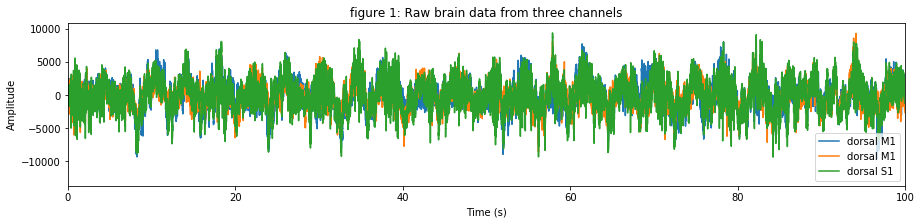

In [6]:
#plot to see raw brain signals from three ECoG channels. 
plt.figure(figsize=(15,3))
plt.plot(np.arange(0,human_ecog_data['ecog_task'].shape[0]/human_ecog_data['fs'],1/human_ecog_data['fs']), 
         human_ecog_data['ecog_task'])
plt.legend(human_ecog_data['labels'])
plt.xlim([0,100])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('figure 1: Raw brain data from three channels')
print(human_ecog_data['ecog_task'].shape)
brain_data = human_ecog_data['ecog_task']
area_1 = brain_data[:,0]
area_2 = brain_data[:,1]
area_3 = brain_data[:,2]
#get frequency vector 
fs = human_ecog_data['fs']
print(fs)
freqs = np.fft.fftfreq(len(area_1), 1/fs)

### Observation: 
The data set contained three channels of ECoG signals, which seemed to contain a lot of different frequencies. The sampling rate was 1000 Hz.  

### 1.  Fourier Transform

We applied Fourier Transform for the three channels of brain signals. Figure 2 below is the plot of power spectrum for all three channels. 

Text(0.5, 1.0, 'figure 2: Power Spectrum')

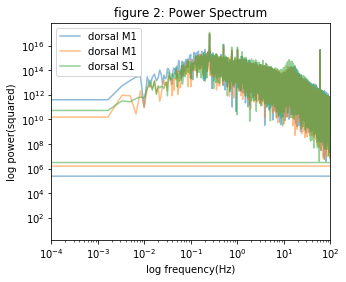

In [7]:
F_fft_1,F_fft_2,F_fft_3 = apply_fourier(area_1,area_2,area_3)
plt.figure(figsize=(5,4))
make_power_spectrum(F_fft_1,F_fft_2,F_fft_3)
plt.title('figure 2: Power Spectrum')

### Observation & Analysis: 
We found the frequencies covered a huge range. The most dominant frequencies were under one hertz, which should be the signals recorded while participants were not doing any task. We decided we will use filter in the later part to see what the other dominant frequencies were when participants were doing tasks. 

### 2. Spectrogram with STFT

Before further analysis, we made a spectrogram for raw data of three channels to see the dominant frequencies over time. 

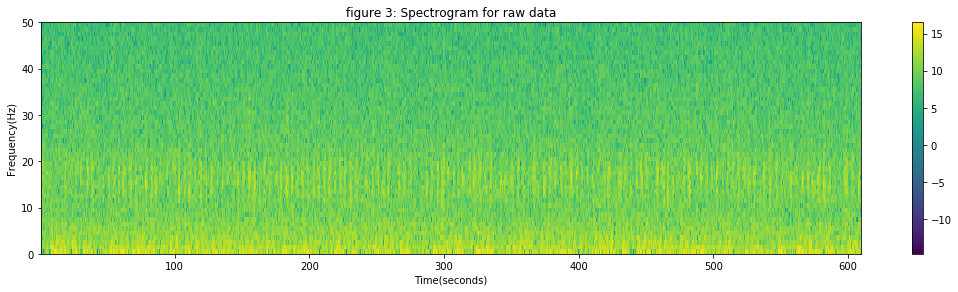

In [8]:
# use STFT 
len_win = 1 
len_overlap = 0.5
f_sp, t_sp, spg_sp = signal.spectrogram(area_1, fs, window='rect', nperseg=int(fs*len_win), noverlap=int(fs*len_overlap), detrend=False)
plot_spectrogram(np.log(spg_sp), t_sp, f_sp, freq_lims=[0,50], plot_db=False)
plt.title('figure 3: Spectrogram for raw data');

### Observation & Analysis: 
The dominant frequencies in this spectrogram were relatively consistent with the power spectrum above. And the dominant frequencies were relatively consistent over time.

### 3. Filter 
First, we applied bandpass filter for a range between 5-100 and plotted the power spectrum to get rid of the dominant frequencies under 1 Hz since they were not really useful for our research goal. We decided to set the max frequency as 100Hz because we were not going to study the frequencies above 100Hz, and this range should already contain most of the dominant frequencies. 

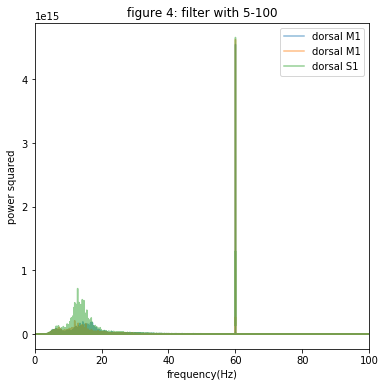

In [9]:
# apply fiter 
filtered_1,filtered_2,filtered_3 = apply_filter([5,100],False,area_1,area_2,area_3)
F_fft_1,F_fft_2,F_fft_3 = apply_fourier(filtered_1,filtered_2,filtered_3)
#compute power 
np_power_1_filtered = np.abs(F_fft_1)**2
np_power_2_filtered = np.abs(F_fft_2)**2
np_power_3_filtered = np.abs(F_fft_3)**2
#plot power spectrum 
plt.figure(figsize=(6,6))
plt.plot(freqs, np_power_1_filtered, alpha=0.5, label=human_ecog_data['labels'][0])
plt.plot(freqs, np_power_2_filtered,  alpha=0.5, label=human_ecog_data['labels'][1])
plt.plot(freqs, np_power_3_filtered, alpha=0.5, label=human_ecog_data['labels'][2])
#plt.legend(human_ecog_data['labels'])
plt.xlabel('frequency(Hz)')
plt.ylabel('power squared')
plt.title('figure 4: filter with 5-100')
plt.xlim([0,100])
plt.legend()

### Obervation & Next step:
Figure 4 above showed a huge contribution from 60Hz, which should be caused by AC lines. After that, we used bandstop filter to filt 60Hz out from raw data and then got the useful range from 5Hz to 100Hz again without that many 60Hz. 

Text(0.5, 1.0, 'figure 6: power spectrum for 5-100Hz')

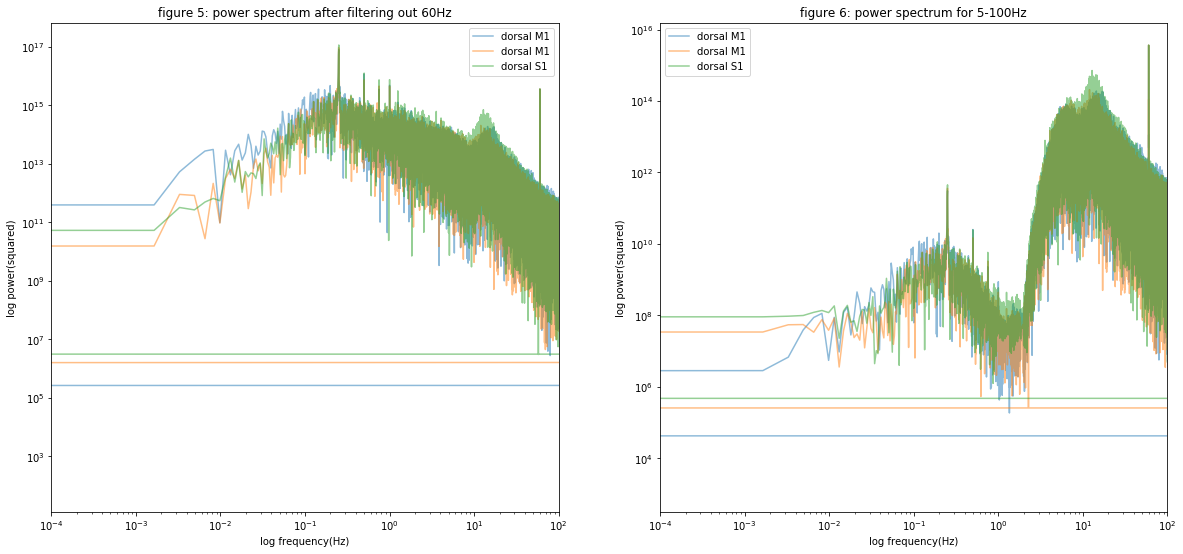

In [11]:
# apply fiter to filt out 60Hz 
filtered_1,filtered_2,filtered_3 = apply_filter([58,62],True,area_1,area_2,area_3)
#apply fourier
F_fft_1_60,F_fft_2_60,F_fft_3_60 = apply_fourier(filtered_1,filtered_2,filtered_3)
#apply filter with a range from 5-100
filtered_1,filtered_2,filtered_3 = apply_filter([5,100],False,filtered_1,filtered_2,filtered_3)
#apply fourier
F_fft_1,F_fft_2,F_fft_3 = apply_fourier(filtered_1,filtered_2,filtered_3)
#make power spectrum
plt.figure(figsize=(20,9))
plt.subplot(1,2,1)
make_power_spectrum(F_fft_1_60,F_fft_2_60,F_fft_3_60)
plt.title('figure 5: power spectrum after filtering out 60Hz')
plt.subplot(1,2,2)
make_power_spectrum(F_fft_1,F_fft_2,F_fft_3)
plt.title('figure 6: power spectrum for 5-100Hz')

### Observation & Next Step: 
Figure 5 was the graph of power spectrum after filtering out 60 Hz. Although 60Hz still existed, its power became much less now. Figure 6 represented the power spectrum which added bandpass filtering between 5Hz to 100Hz to figure 5. Comparing the log graph after applying bandstop around 60Hz(figure at the left) and then applying bandpass filter at 5-100Hz(figure at the right), we saw dominant frequencies contained a lot of gamma oscillation and theta oscillation. We planned to do theta phase and gamma amplitude coupling.

### 4. Theta-Gamma coupling

We separated brain data according to different finger reaction.
We set the theta range to be from 4Hz to 10Hz, because theta frequency is typically around 4Hz to 10Hz. We set the gamma range to be from 30Hz to 50Hz, because gamma frequency is typically around 30-50Hz. These two ranges were consistant with previous research. (Codes for filtering parts were included in funcions at the top help function section.)

In [13]:
#seperate brain data according to different finger reaction  
reaction = human_ecog_data['stim']
finger_1 = np.array(np.where(reaction == 1)[0])
finger_2 = np.array(np.where(reaction == 2)[0])
finger_3 = np.array(np.where(reaction == 3)[0])
finger_4 = np.array(np.where(reaction == 4)[0])
finger_5 = np.array(np.where(reaction == 5)[0])

Text(0.5, 1.0, 'figure 7.15: finger 5 channel 3')

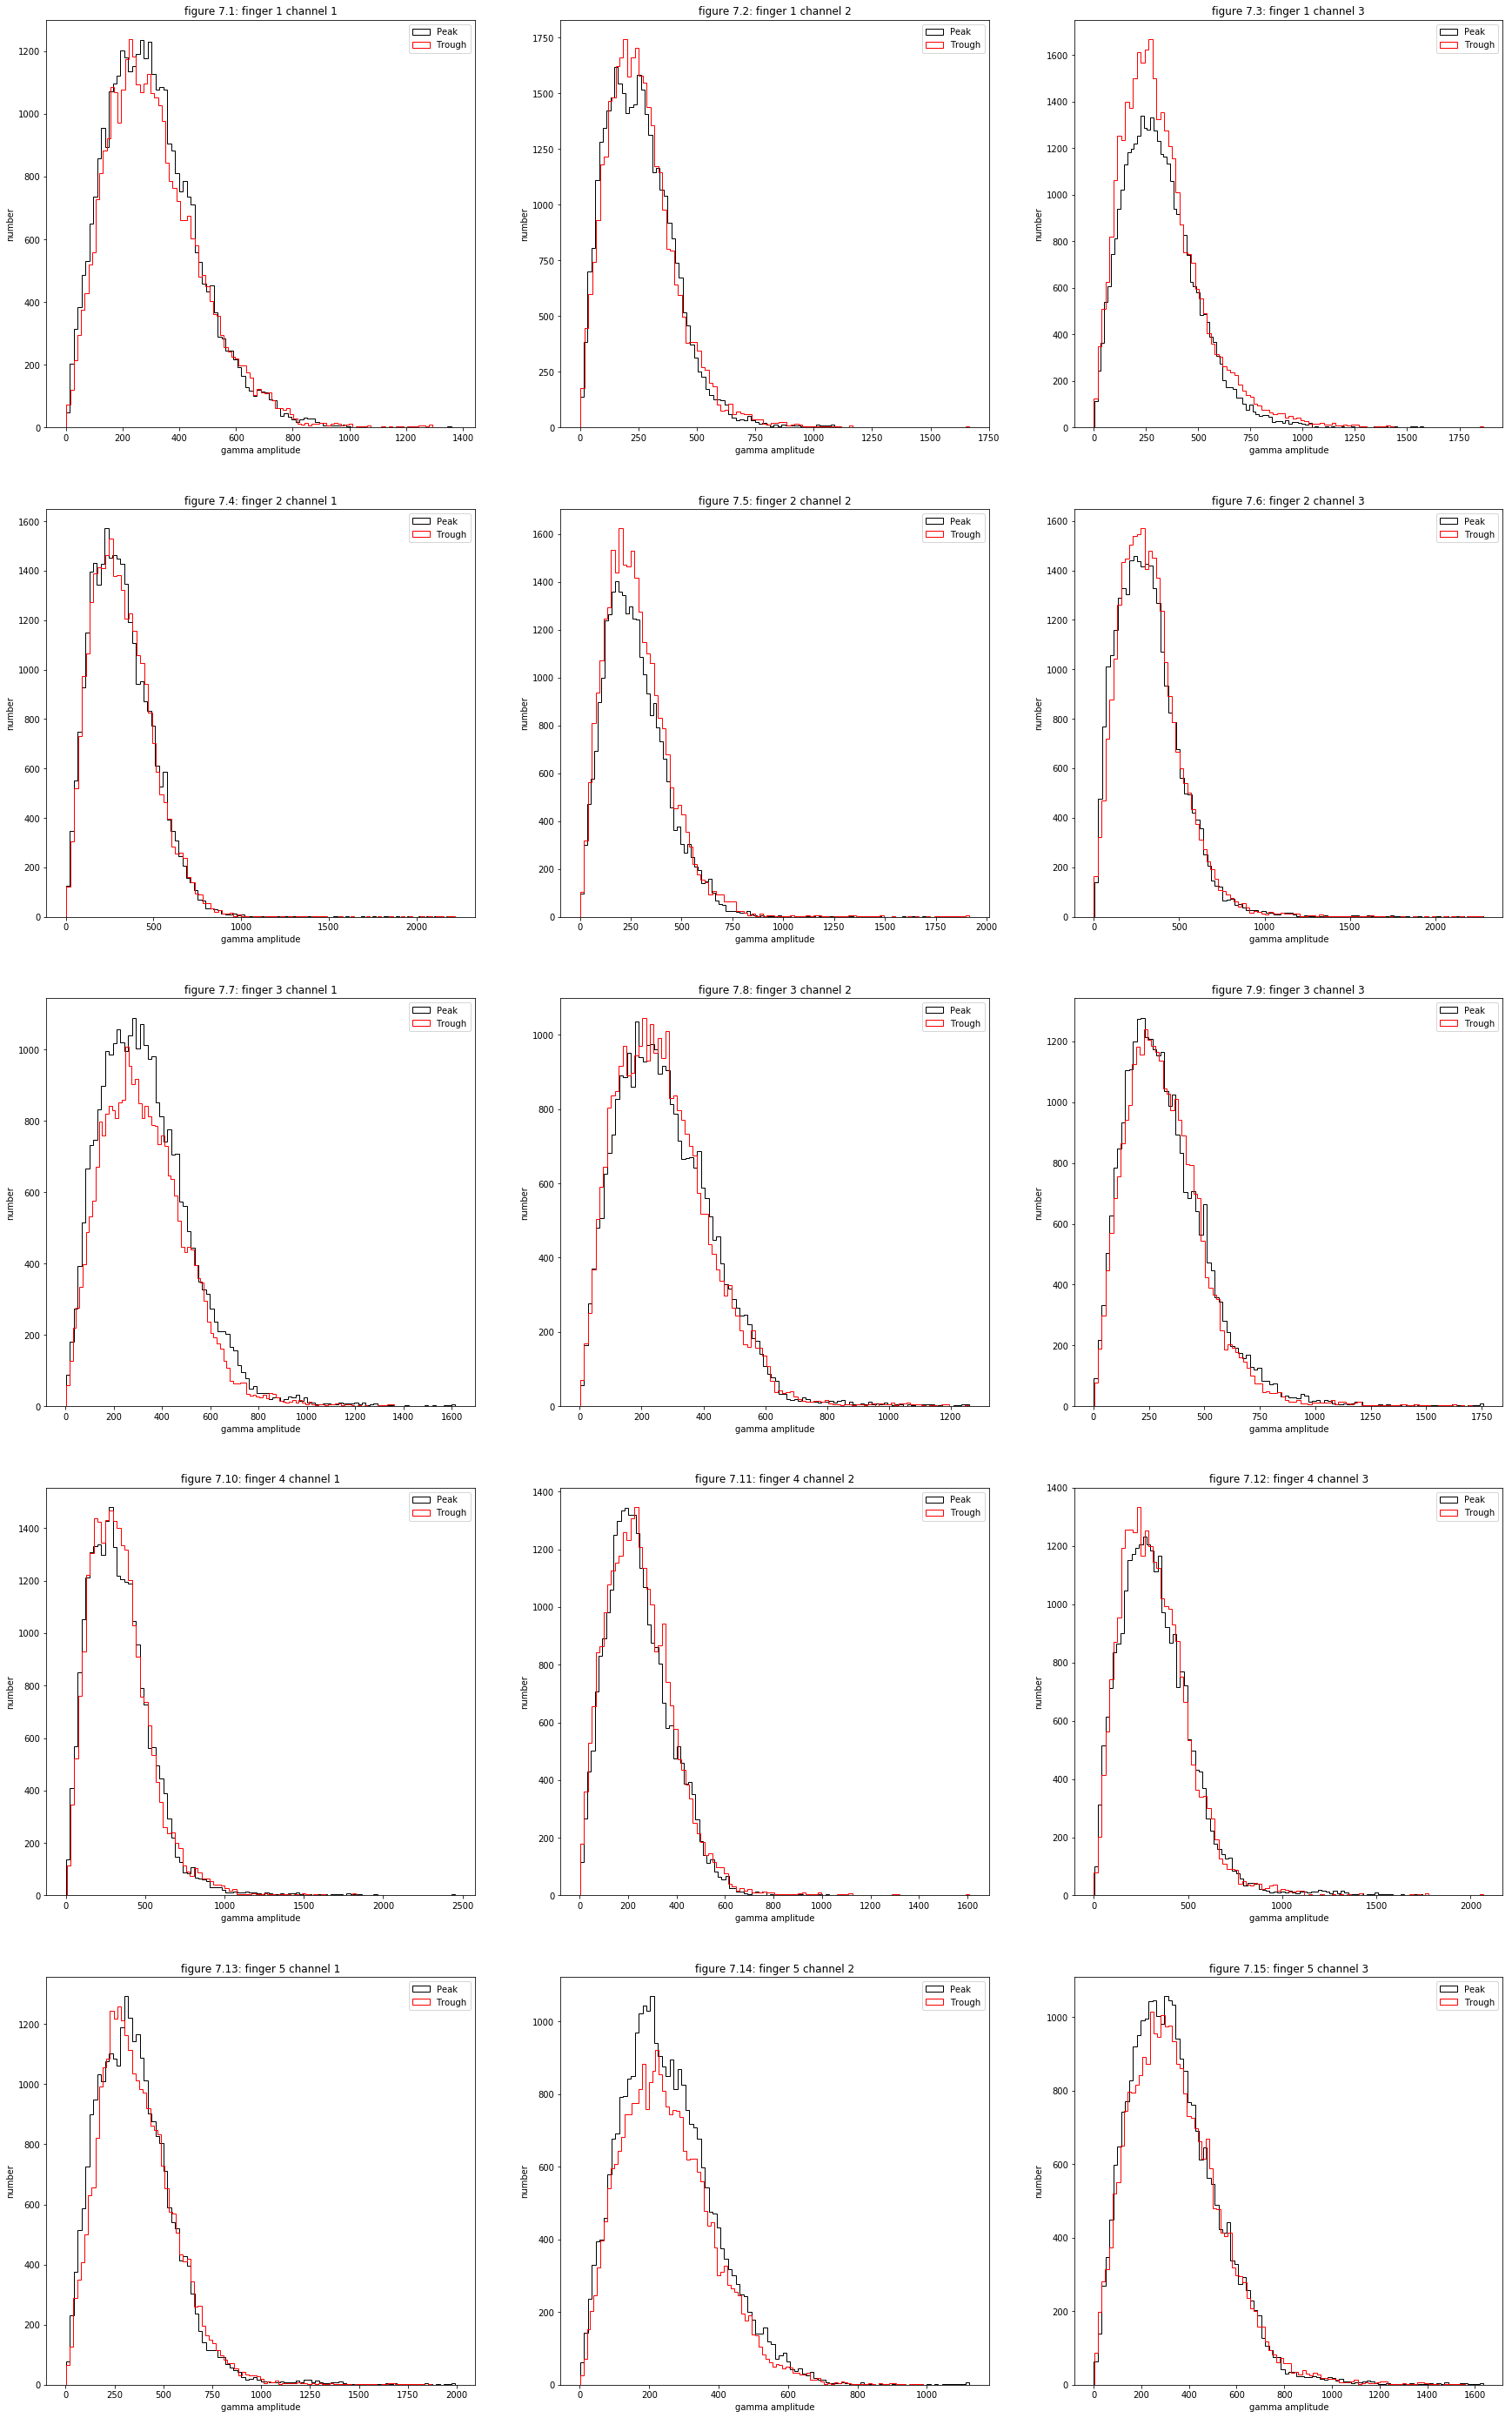

In [14]:
plt.figure(figsize=(30,50))
#finger 1 
plt.subplot(5,3,1)
make_finger_plot_1(area_1[finger_1])
plt.title('figure 7.1: finger 1 channel 1')
plt.subplot(5,3,2)
make_finger_plot_1(area_2[finger_1])
plt.title('figure 7.2: finger 1 channel 2')
plt.subplot(5,3,3)
make_finger_plot_1(area_3[finger_1])
plt.title('figure 7.3: finger 1 channel 3')

#finger 2 
plt.subplot(5,3,4)
make_finger_plot_1(area_1[finger_2])
plt.title('figure 7.4: finger 2 channel 1')
plt.subplot(5,3,5)
make_finger_plot_1(area_2[finger_2])
plt.title('figure 7.5: finger 2 channel 2')
plt.subplot(5,3,6)
make_finger_plot_1(area_3[finger_2])
plt.title('figure 7.6: finger 2 channel 3')

#finger 3
plt.subplot(5,3,7)
make_finger_plot_1(area_1[finger_3])
plt.title('figure 7.7: finger 3 channel 1')
plt.subplot(5,3,8)
make_finger_plot_1(area_2[finger_3])
plt.title('figure 7.8: finger 3 channel 2')
plt.subplot(5,3,9)
make_finger_plot_1(area_3[finger_3])
plt.title('figure 7.9: finger 3 channel 3')

#finger 4 
plt.subplot(5,3,10)
make_finger_plot_1(area_1[finger_4])
plt.title('figure 7.10: finger 4 channel 1')
plt.subplot(5,3,11)
make_finger_plot_1(area_2[finger_4])
plt.title('figure 7.11: finger 4 channel 2')
plt.subplot(5,3,12)
make_finger_plot_1(area_3[finger_4])
plt.title('figure 7.12: finger 4 channel 3')
#finger 5 
plt.subplot(5,3,13)
make_finger_plot_1(area_1[finger_5])
plt.title('figure 7.13: finger 5 channel 1')
plt.subplot(5,3,14)
make_finger_plot_1(area_2[finger_5])
plt.title('figure 7.14: finger 5 channel 2')
plt.subplot(5,3,15)
make_finger_plot_1(area_3[finger_5])
plt.title('figure 7.15: finger 5 channel 3')

Text(0.5, 1.0, 'figure 8.15: finger 5 channel 3')

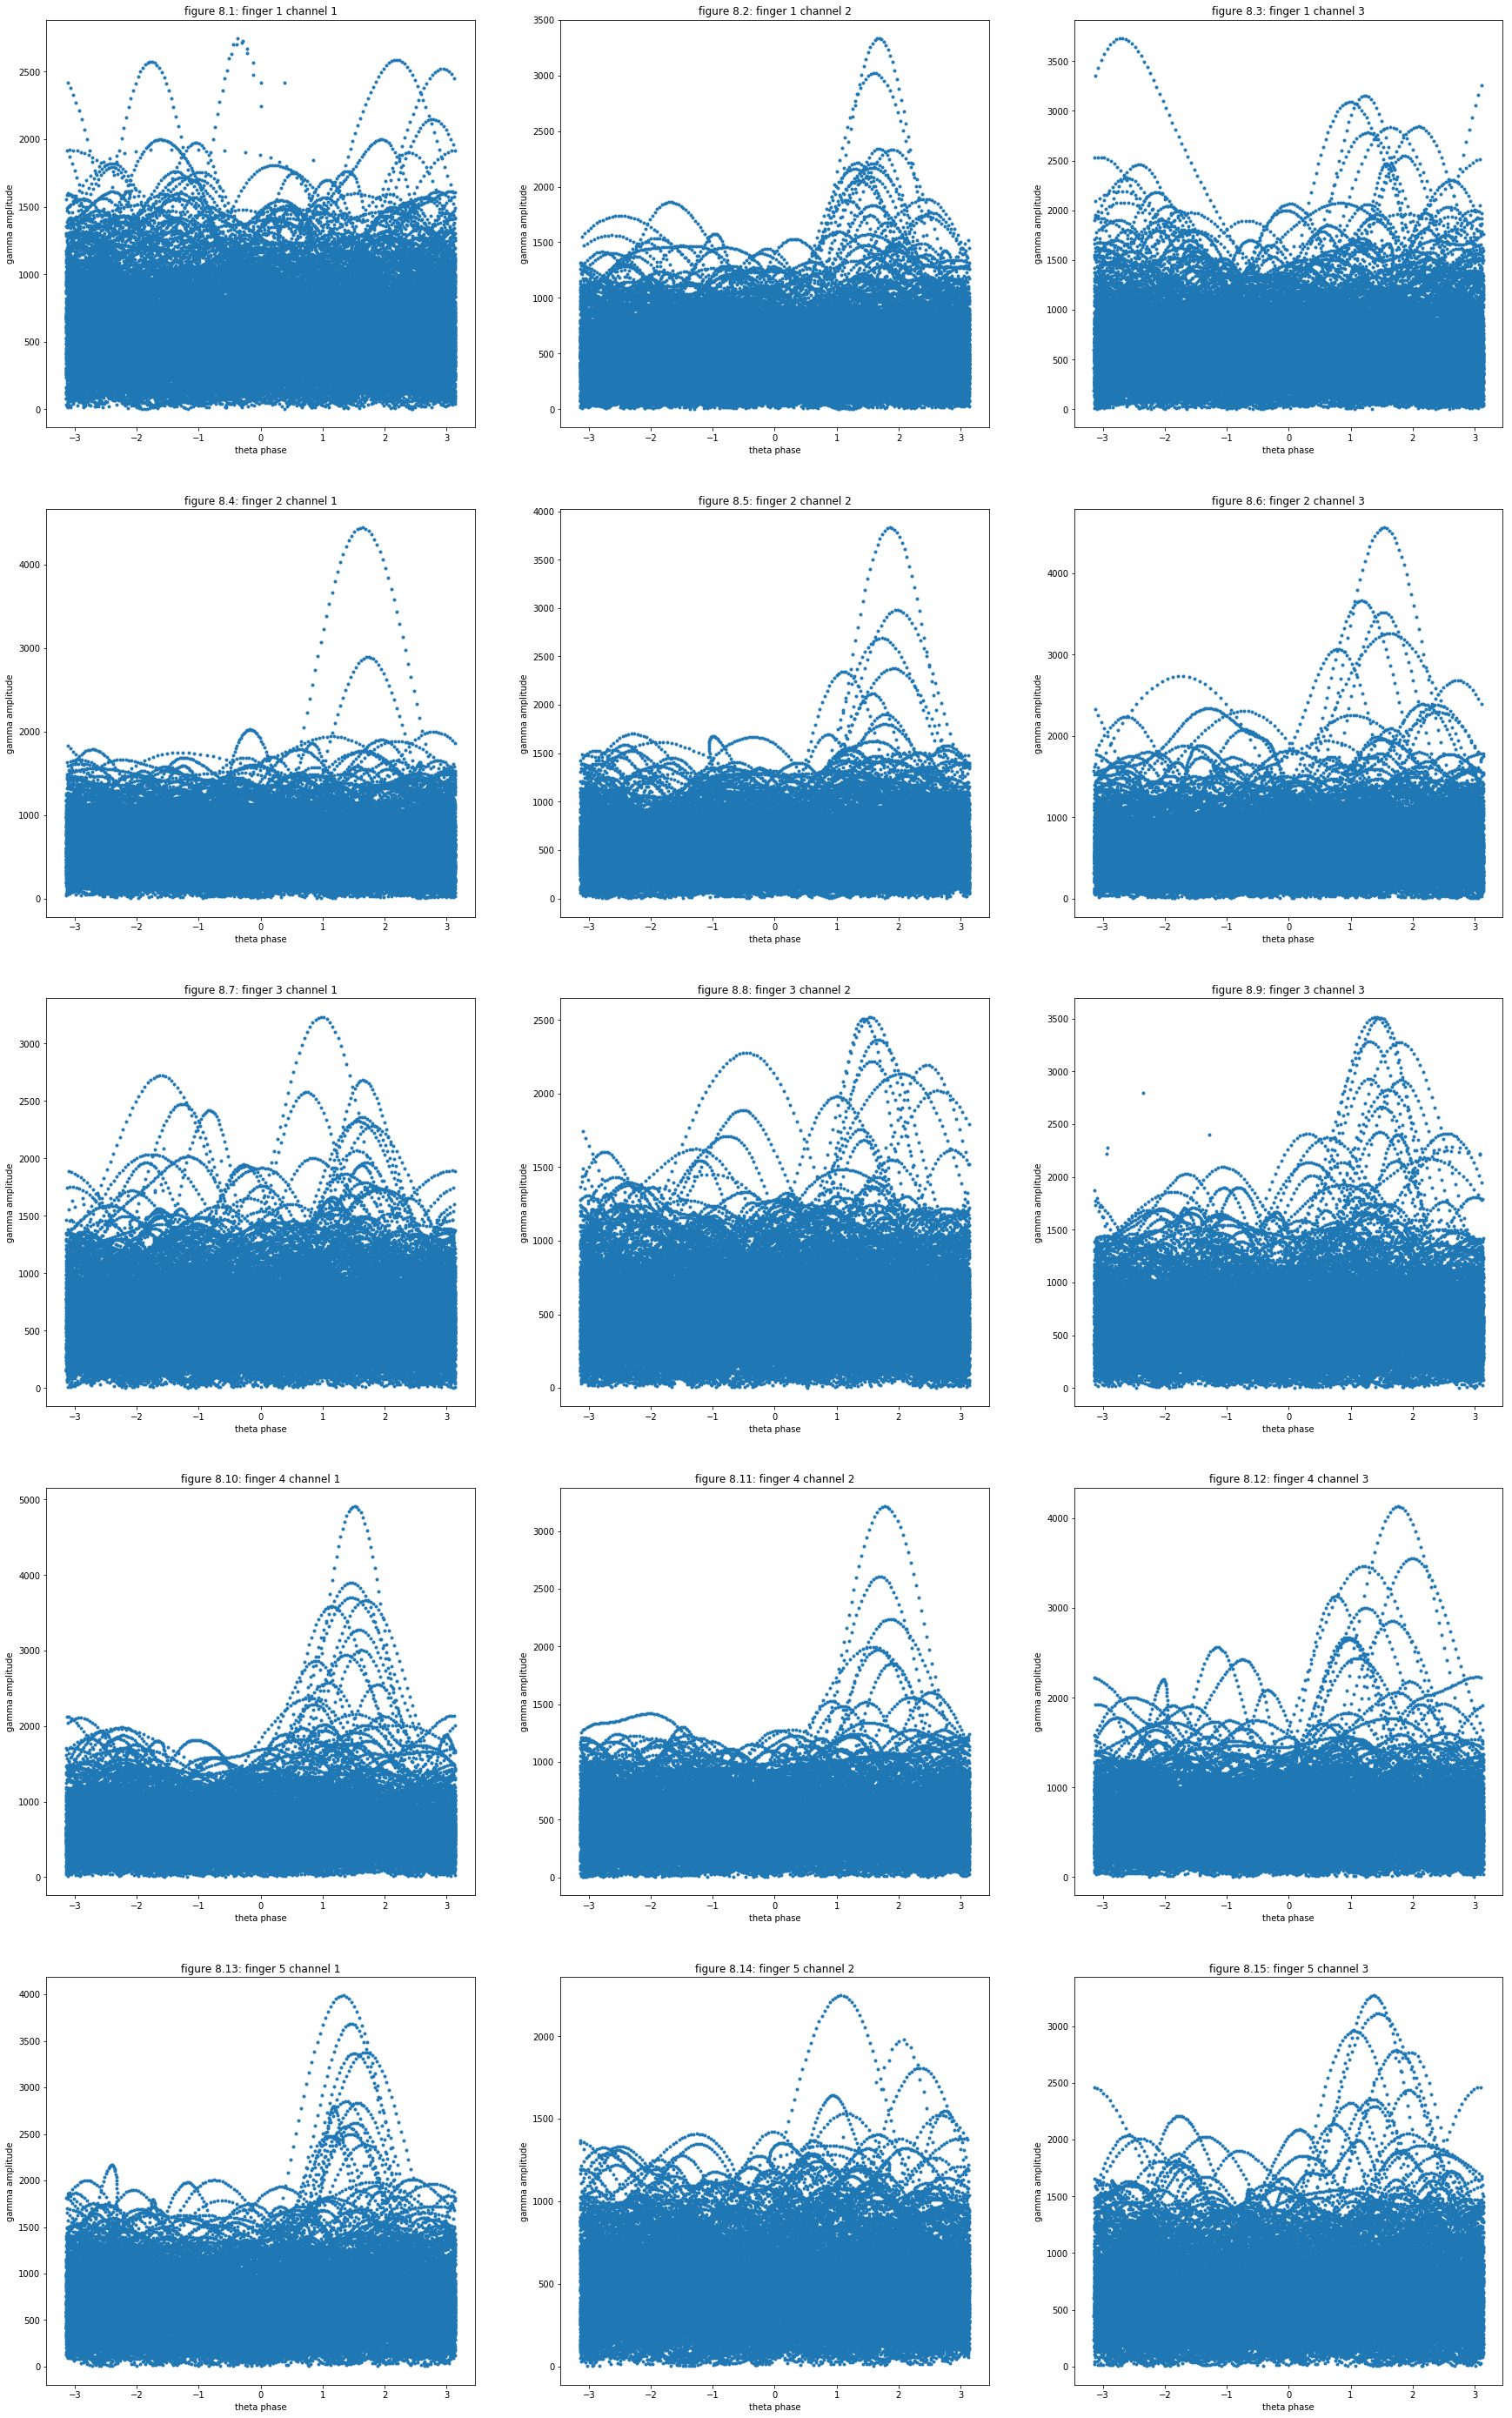

In [15]:
plt.figure(figsize=(30,50))
#finger 1 
plt.subplot(5,3,1)
make_finger_plot_2(area_1[finger_1])
plt.title('figure 8.1: finger 1 channel 1')
plt.subplot(5,3,2)
make_finger_plot_2(area_2[finger_1])
plt.title('figure 8.2: finger 1 channel 2')
plt.subplot(5,3,3)
make_finger_plot_2(area_3[finger_1])
plt.title('figure 8.3: finger 1 channel 3')

#finger 2 
plt.subplot(5,3,4)
make_finger_plot_2(area_1[finger_2])
plt.title('figure 8.4: finger 2 channel 1')
plt.subplot(5,3,5)
make_finger_plot_2(area_2[finger_2])
plt.title('figure 8.5: finger 2 channel 2')
plt.subplot(5,3,6)
make_finger_plot_2(area_3[finger_2])
plt.title('figure 8.6: finger 2 channel 3')

#finger 3
plt.subplot(5,3,7)
make_finger_plot_2(area_1[finger_3])
plt.title('figure 8.7: finger 3 channel 1')
plt.subplot(5,3,8)
make_finger_plot_2(area_2[finger_3])
plt.title('figure 8.8: finger 3 channel 2')
plt.subplot(5,3,9)
make_finger_plot_2(area_3[finger_3])
plt.title('figure 8.9: finger 3 channel 3')

#finger 4 
plt.subplot(5,3,10)
make_finger_plot_2(area_1[finger_4])
plt.title('figure 8.10: finger 4 channel 1')
plt.subplot(5,3,11)
make_finger_plot_2(area_2[finger_4])
plt.title('figure 8.11: finger 4 channel 2')
plt.subplot(5,3,12)
make_finger_plot_2(area_3[finger_4])
plt.title('figure 8.12: finger 4 channel 3')

#finger 5 
plt.subplot(5,3,13)
make_finger_plot_2(area_1[finger_5])
plt.title('figure 8.13: finger 5 channel 1')
plt.subplot(5,3,14)
make_finger_plot_2(area_2[finger_5])
plt.title('figure 8.14: finger 5 channel 2')
plt.subplot(5,3,15)
make_finger_plot_2(area_3[finger_5])
plt.title('figure 8.15: finger 5 channel 3')

###  Observation & Analysis
Both figure 7 and figure 8 seriers above showed us the coupling result between theta phase and gamma amplitude. Figure 7 showed the distribution of gamma amplitude value during trough and peak phase of theta oscilaltion while figure 8 plotted theta phase as x-axis and gamma amplitude as y-axis.
We found coupling of theta phase and gamma power did exist during the movement of all five fingers. Gamma amplitude was usually larger at the trough phase of theta oscillation. However, the relationships was not as significant as the ones found in previous study conducted by Canolty and his colleagues (2006). Some possible reasons for this weaker relationship would be discussed in the following Limitation section.

### 5. Correlation
We wanted to calculate and compare the correlation between brain signals (from three channels seperately) and actual finger flexion of each finger.

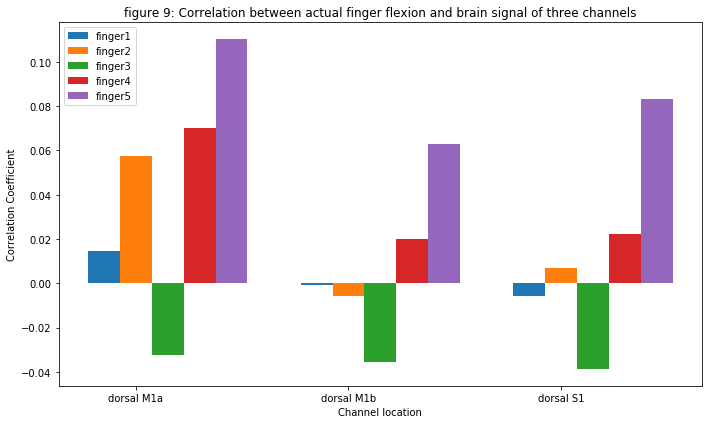

In [16]:
#calculate correaltion between brain signal and each finger 
finger_flexion = human_ecog_data['flex']
finger_1 = finger_flexion[:,0]
finger_2 = finger_flexion[:,1]
finger_3 = finger_flexion[:,2]
finger_4 = finger_flexion[:,3]
finger_5 = finger_flexion[:,4]
reaction = human_ecog_data['stim']
#rest = np.array(np.where(reaction <=0)[0])
movement = np.array(np.where(reaction > 0)[0])
finger1_area_1 = np.corrcoef(area_1[movement],finger_1[movement])
finger2_area_1 = np.corrcoef(area_1[movement],finger_2[movement])
finger3_area_1 = np.corrcoef(area_1[movement],finger_3[movement])
finger4_area_1 = np.corrcoef(area_1[movement],finger_4[movement])
finger5_area_1 = np.corrcoef(area_1[movement],finger_5[movement])
finger1_area_2 = np.corrcoef(area_2[movement],finger_1[movement])
finger2_area_2 = np.corrcoef(area_2[movement],finger_2[movement])
finger3_area_2 = np.corrcoef(area_2[movement],finger_3[movement])
finger4_area_2 = np.corrcoef(area_2[movement],finger_4[movement])
finger5_area_2 = np.corrcoef(area_2[movement],finger_5[movement])
finger1_area_3 = np.corrcoef(area_3[movement],finger_1[movement])
finger2_area_3 = np.corrcoef(area_3[movement],finger_2[movement])
finger3_area_3 = np.corrcoef(area_3[movement],finger_3[movement])
finger4_area_3 = np.corrcoef(area_3[movement],finger_4[movement])
finger5_area_3 = np.corrcoef(area_3[movement],finger_5[movement])

finger_1_correlation = [finger1_area_1[1][0],finger1_area_2[1][0],finger1_area_3[1][0]]
finger_2_correlation = [finger2_area_1[1][0],finger2_area_2[1][0],finger2_area_3[1][0]]
finger_3_correlation = [finger3_area_1[1][0],finger3_area_2[1][0],finger3_area_3[1][0]]
finger_4_correlation = [finger4_area_1[1][0],finger4_area_2[1][0],finger4_area_3[1][0]]
finger_5_correlation = [finger5_area_1[1][0],finger5_area_2[1][0],finger5_area_3[1][0]]

plt.figure(figsize=(10,6))
n_groups = 3
index = np.arange(n_groups)
bar_width = 0.15
opacity = 0.8

finger_1 = plt.bar(index, finger_1_correlation, bar_width,label='finger1')
finger_2 = plt.bar(index + bar_width, finger_2_correlation, bar_width,label='finger2')
finger_3 = plt.bar(index + 2*bar_width, finger_3_correlation, bar_width,label='finger3')
finger_4 = plt.bar(index + 3*bar_width, finger_4_correlation, bar_width,label='finger4')
finger_5 = plt.bar(index + 4*bar_width, finger_5_correlation, bar_width,label='finger5')

plt.xlabel('Channel location')
plt.ylabel('Correlation Coefficient')
plt.title('figure 9: Correlation between actual finger flexion and brain signal of three channels')
plt.xticks(index + bar_width, ('dorsal M1a', 'dorsal M1b', 'dorsal S1'))
plt.legend()
plt.tight_layout()
plt.show()

### Observation & Analysis

Overall, finger1, finger 2, and finger 3 had less correlation with brain signals while finger 4 and finger 5 had stronger correlation. It might be caused by cognitive efficiency theory suggested by Hoffman (2011). Finger 4 and 5 seemed to be the two fingers which we use less, so it would take more energy/attention of the brain to move finger 4 and 5, while the brain does not need to take that much care for finger1, 2, and 3. 
The correlation between finger flexion and brain signals was different for different fingers. The correlation coefficient had small magnitude for all the fingers, which might because the brain signals can be affected by many other factors, while the flexion vector was only recorded from each finger seperately. Finger might not be able to affect brain signal that much.
Although the correlation was small, the discrepancy of correlation coefficient for different fingers was relatively consistent through all three channels. This suggested there was some consistent relationship between brain signals and different fingers, and there was some relatively consistent difference among different fingers. 


### 5. Correlation - Continued
We computed correlation of ECoG signals from M1a, M1b, and S1. We used the 'stim' parameter instead of the 'cue' parameter because there was typically a delay in response for each subject, and the 'stim', which showed the actual response of a subject, would be more representative of the finger movement after presented the cue.

In [17]:
#get the reponse parameter
response = human_ecog_data['stim']
# create task ECoG dataframe
df = pd.DataFrame(human_ecog_data['ecog_task'], columns=['Dorsal_M1a', 'Dorsal_M1b', 'Dorsal_S1'])

            Dorsal_M1a  Dorsal_M1b  Dorsal_S1
Dorsal_M1a    1.000000    0.570791   0.716214
Dorsal_M1b    0.570791    1.000000   0.716149
Dorsal_S1     0.716214    0.716149   1.000000


Text(0.5, 1.0, 'figure 10: Correlation of brain signals from three channels')

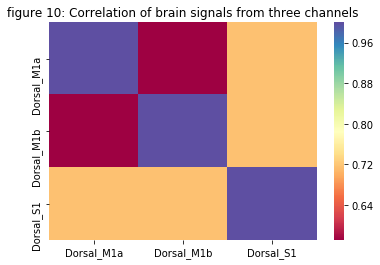

In [18]:
# create correlation matrix
corr_matrix(df)
plt.title('figure 10: Correlation of brain signals from three channels')

### Observation & Analysis: 
As you can see from the correlation matrix (figure 10), there was surprisingly a higher correlation between each ECoG signals from M1 sensors and S1 sensors (M1a & S1, M1b & S1) than ECoG signals between both M1 sensors (M1a & M1b). One possible explanation for this observation was that the two M1 sensors were actually measuring brain areas corresponding to different fingers that were far apart, such as thumb and pinky finger; and the S1 sensor was actually measuring brain area related to every finger. However, we would not know if that was actually the case since it was not mentioned in the original research paper.

We plotted the scatter plots between each region along with the least-square regression line for each plot. 

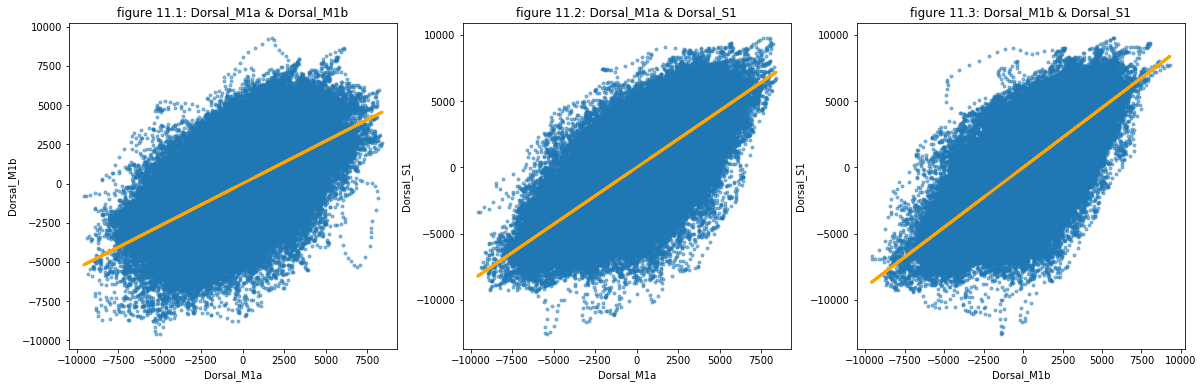

In [19]:
# plot regression plot for three dimensions
plt.figure(figsize=(20,6))
plt.subplot(1, 3, 1)
regression_plot(df, 'Dorsal_M1a', 'Dorsal_M1b')
plt.title('figure 11.1: Dorsal_M1a & Dorsal_M1b')

plt.subplot(1, 3, 2)
regression_plot(df, 'Dorsal_M1a', 'Dorsal_S1')
plt.title('figure 11.2: Dorsal_M1a & Dorsal_S1')

plt.subplot(1, 3, 3)
regression_plot(df, 'Dorsal_M1b', 'Dorsal_S1')
plt.title('figure 11.3: Dorsal_M1b & Dorsal_S1')
plt.show()

### Observation & Analysis: 
To visualize how ECoG signals were correlated with each other, we plotted the scatter plots between each region along with the least-square regression line for each plot in figure 11 series. The plot for M1a & S1 and M1b & S1 seemed to be more condensed than M1a & M1b. 

### 6. Dimensionality Reduction
We reduced the three ECoG channels into one principal component using dimensionality reduction and plotted this combined signal.

Text(0.5, 1.0, 'figure 12: PCA dimensionality reduced ECoG signal')

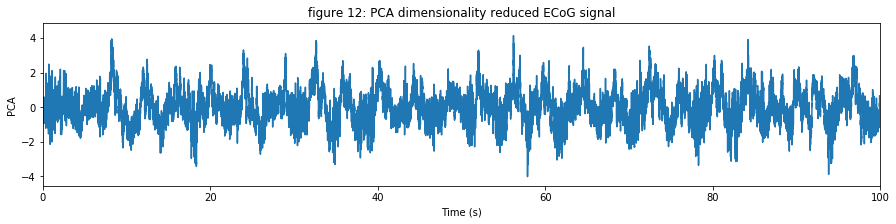

In [20]:
#Combined ECoG data from three channels using PCA 
dim_red_total = pca_fit(df, 'Dorsal_M1a', 'Dorsal_M1b', 'Dorsal_S1')
plt.title('figure 12: PCA dimensionality reduced ECoG signal')

### Observation & Analysis: 
Figure 12 showed the dimensionally reduced ECoG signals from three channels using PCA method. The reason why we combined three ECoG channels' signals into one was that we did not only want to see how ECoG signals were correlated within each channel, but how they were correlated with a consolidated comprehensive ECoG signal that was more representative of the whole response process. Dimensionality reduction method was the best way to find the principal components and to reduce the data to be most representative with less dimensions.

### 5. Correlation - Continued
We made the correlation matrix between the ECoG signals recorded in three electrodes and the PCA dimensionality reduced ECoG signal.

              Dorsal_M1a  Dorsal_M1b  Dorsal_S1  PCA Combined
Dorsal_M1a      1.000000    0.570791   0.716214     -0.852768
Dorsal_M1b      0.570791    1.000000   0.716149     -0.836579
Dorsal_S1       0.716214    0.716149   1.000000     -0.948181
PCA Combined   -0.852768   -0.836579  -0.948181      1.000000


Text(0.5, 1.0, 'figure 13: Correlation between each channel with PCA signal')

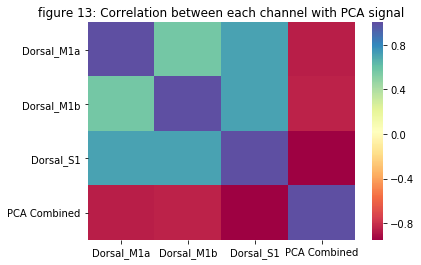

In [21]:
#correaltion between different PCA channels 
df_corr = create_df([df['Dorsal_M1a'], df['Dorsal_M1b'], df['Dorsal_S1'], dim_red_total[:,0]], ['Dorsal_M1a', 'Dorsal_M1b', 'Dorsal_S1', 'PCA Combined'])
corr_matrix(df_corr)
plt.title('figure 13: Correlation between each channel with PCA signal')

### Observation & Analysis: 
Figure 13 showed a correlation matrix between the ECoG signals recorded in three electrodes and the PCA dimensionality reduced ECoG signal. The PCA dimensionality reduced ECoG signal had a high correlation (over 0.8) with all the other channels, which suggested that the PCA ECoG signal is quite representative of all the three electrodes' signals. 

### 8. Epoching & ECoG averaging
We epoched a 6-second window to capture the time-locked signals during individual finger movement response. We set the onset time (0s) to be the start of each finger response so that we could see more consistent ECoG signal change and signals would not be affected by various time delay. The following plots were ECoG signals (grey) and averaged ECoG signals (blue) of each finger from the three electrodes (Dorsal M1a, Dorsal M1b, Dorsal S1) and the PCA dimensionality reduced ECoG signal.

Below are __figure 14__: ECoG Averaging of  each channel for each finger

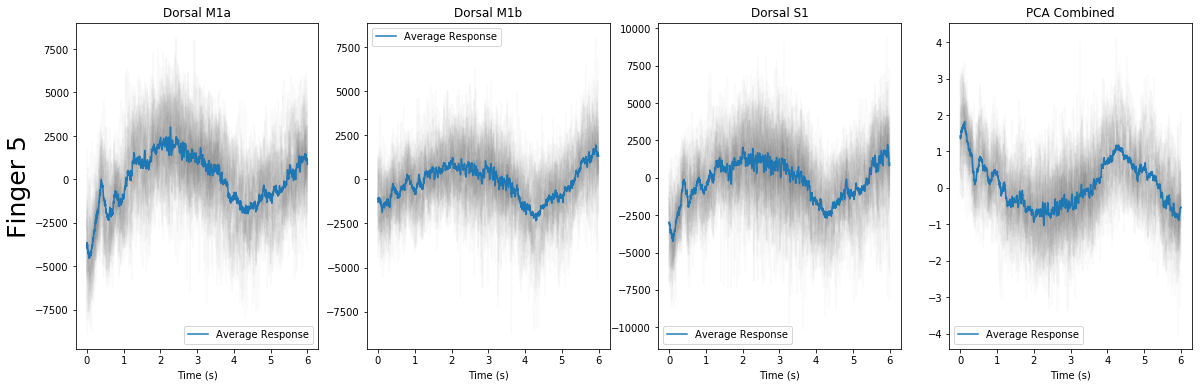

              Dorsal_M1  Dorsal_M2  Dorsal_S1  PCA Combined
Dorsal_M1      1.000000   0.811205   0.942761     -0.966256
Dorsal_M2      0.811205   1.000000   0.911955     -0.923458
Dorsal_S1      0.942761   0.911955   1.000000     -0.992183
PCA Combined  -0.966256  -0.923458  -0.992183      1.000000


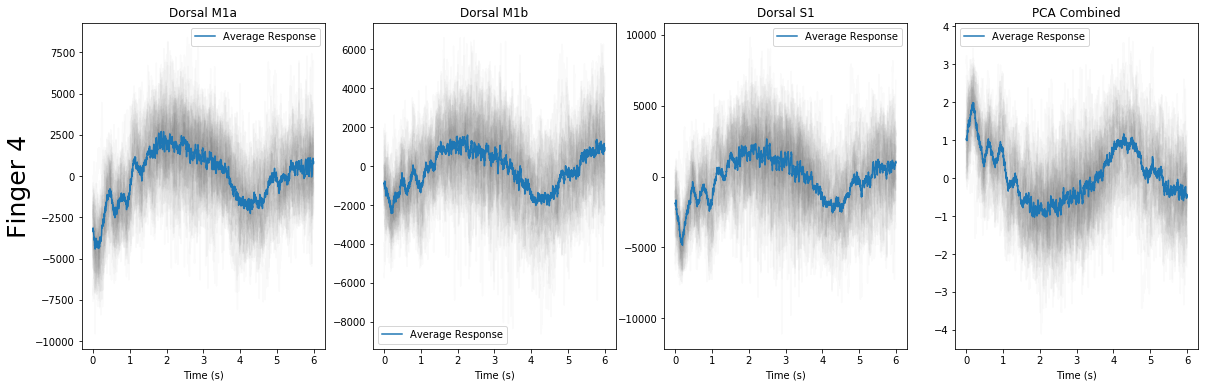

              Dorsal_M1  Dorsal_M2  Dorsal_S1  PCA Combined
Dorsal_M1      1.000000   0.894115   0.961391     -0.980446
Dorsal_M2      0.894115   1.000000   0.933693     -0.952706
Dorsal_S1      0.961391   0.933693   1.000000     -0.992543
PCA Combined  -0.980446  -0.952706  -0.992543      1.000000


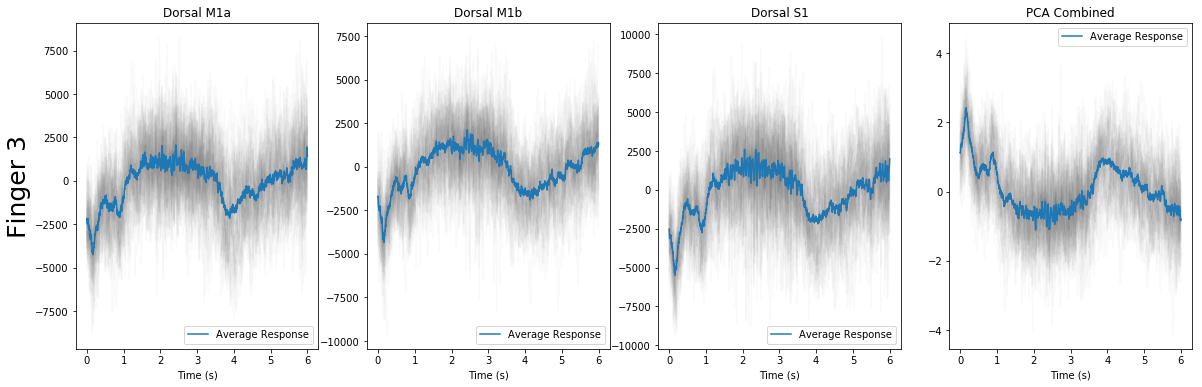

              Dorsal_M1  Dorsal_M2  Dorsal_S1  PCA Combined
Dorsal_M1      1.000000   0.956214   0.970507     -0.985019
Dorsal_M2      0.956214   1.000000   0.973829     -0.985726
Dorsal_S1      0.970507   0.973829   1.000000     -0.995082
PCA Combined  -0.985019  -0.985726  -0.995082      1.000000


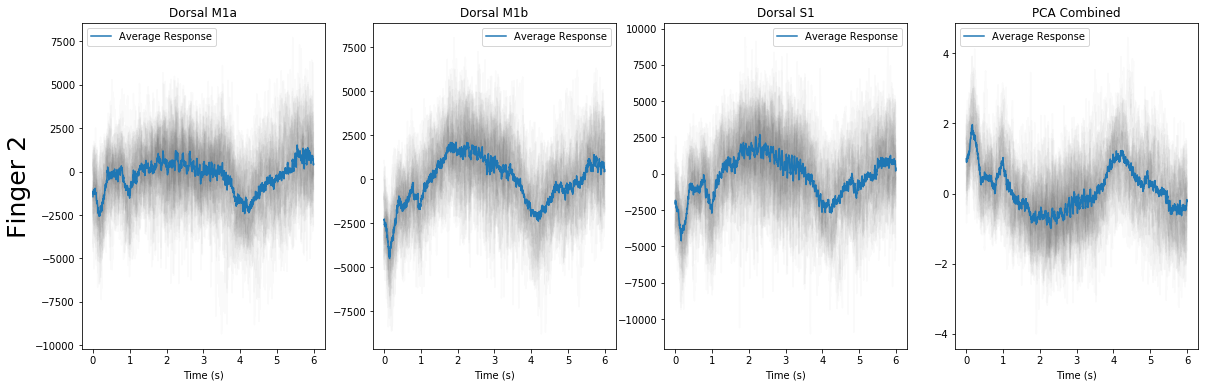

              Dorsal_M1  Dorsal_M2  Dorsal_S1  PCA Combined
Dorsal_M1      1.000000   0.860927   0.891472     -0.928838
Dorsal_M2      0.860927   1.000000   0.968008     -0.980014
Dorsal_S1      0.891472   0.968008   1.000000     -0.991807
PCA Combined  -0.928838  -0.980014  -0.991807      1.000000


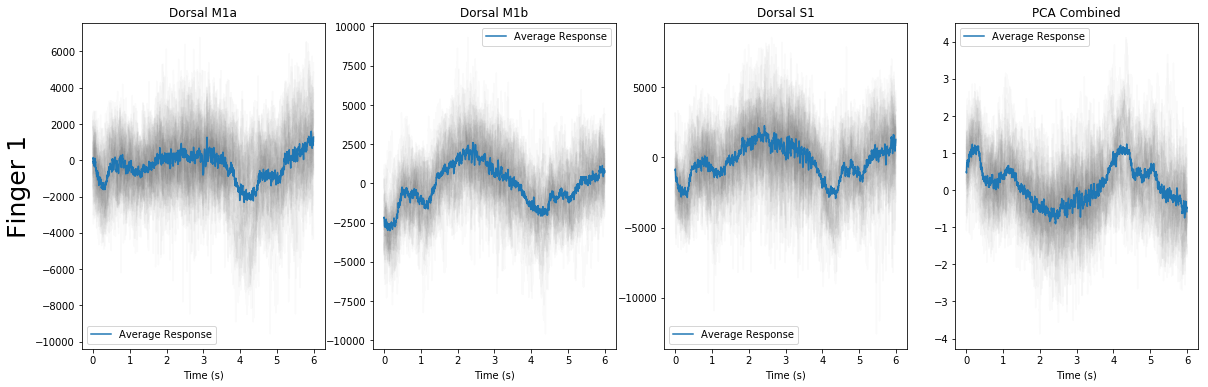

              Dorsal_M1  Dorsal_M2  Dorsal_S1  PCA Combined
Dorsal_M1      1.000000   0.736998   0.856703     -0.884746
Dorsal_M2      0.736998   1.000000   0.940614     -0.957850
Dorsal_S1      0.856703   0.940614   1.000000     -0.991622
PCA Combined  -0.884746  -0.957850  -0.991622      1.000000


In [23]:
summary(5) # summary plots for finger 5
summary(4) # summary plots for finger 4
summary(3) # summary plots for finger 3
summary(2) # summary plots for finger 2
summary(1) # summary plots for finger 1

### Observation & Analysis: 
Figure 14 showed ECoG signals (grey) and averaged ECoG signals (blue) of each finger from the three electrodes (Dorsal M1a, Dorsal M1b, Dorsal S1) and the PCA dimensionality reduced ECoG signal. The reason why we used 6 seconds window was that we found most of the response time was around 3 to 4 seconds, and there was only one exception where the participant responded for more than 6 seconds which contained two cues. There was a consistent bump/increase in the ECoG signals over three channels and a decrease in PCA dimensionality reduced ECoG signal. The decrease in PCA was due to the flipped orthogonal basis while conducting dimensionality reduction. The correlation matrix between signals from each region for each specific finger showed the PCA dimensionality reduced ECoG signal was highly correlated with ECoG signals from other channels. The response was also relatively consistent for each figer with minor difference. 

### Random Onset ECoG Signal Averaging
We computed 100 randomly selected onset time throughout the whole signals for each channel. We chose 100 randomly onset time because there were around 100 trials in total for the whole experiment. 

Below are __figure 15__: ECoG averaging of randomly selected onsets for each channel

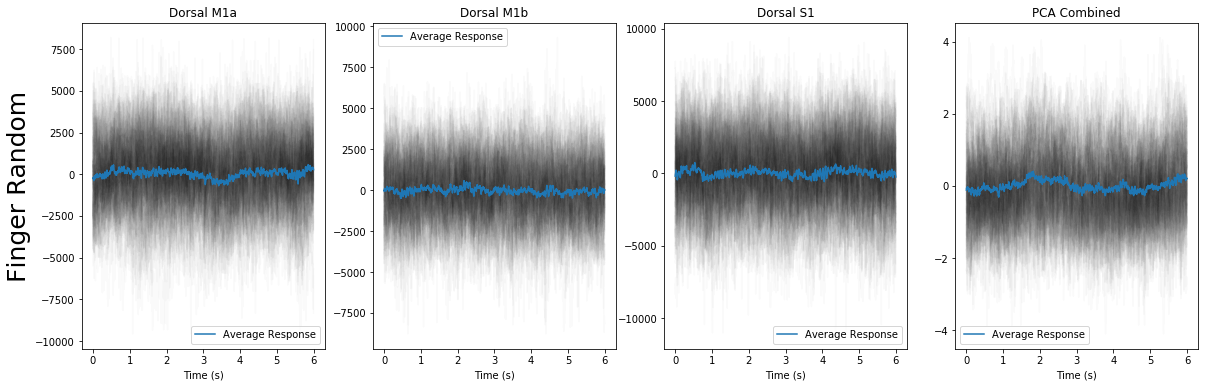

              Dorsal_M1  Dorsal_M2  Dorsal_S1  PCA Combined
Dorsal_M1      1.000000   0.006656   0.266768      0.278399
Dorsal_M2      0.006656   1.000000  -0.037713      0.166047
Dorsal_S1      0.266768  -0.037713   1.000000      0.048181
PCA Combined   0.278399   0.166047   0.048181      1.000000


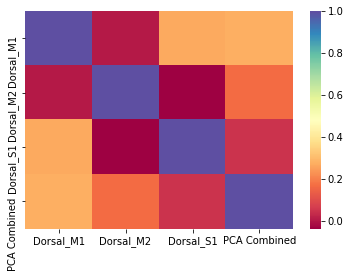

In [24]:
random_summary('Random') # summary for random data

### Observation & Analysis: 
Compared with the ECoG averaging of 100 randomly selected onset time throughout the whole signals for each channel (figure 15), which was almost a flat line around 0, the bump in the three channels and decrease in PCA ECoG signals suggested that finger movement did cause changes in brain signals consistently while the brain signals only had minor difference. There was further implication for predictions of finger movements using brain signals.

### 5. Correlation - Continued
We made a correlation matrix of brain signals of each finger for each channel (Dorsal M1a, Dorsal M1b, Dorsal S1 & PCA).

__Dorsal M1a__

          Finger 1  Finger 2  Finger 3  Finger 4  Finger 5
Finger 1  1.000000  0.816282  0.589669  0.599954  0.604831
Finger 2  0.816282  1.000000  0.780266  0.768125  0.756791
Finger 3  0.589669  0.780266  1.000000  0.913776  0.861137
Finger 4  0.599954  0.768125  0.913776  1.000000  0.948087
Finger 5  0.604831  0.756791  0.861137  0.948087  1.000000


Text(0.5, 1.0, 'figure 16.1: Dorsal M1a correlation of individual finger')

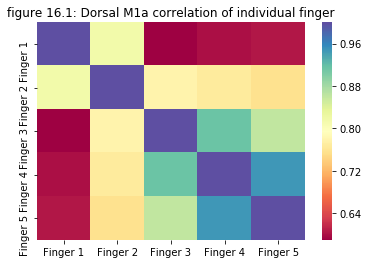

In [25]:
finger_summary('Dorsal_M1a')
plt.title('figure 16.1: Dorsal M1a correlation of individual finger')

__Dorsal M1b__

          Finger 1  Finger 2  Finger 3  Finger 4  Finger 5
Finger 1  1.000000  0.927244  0.887855  0.880094  0.804272
Finger 2  0.927244  1.000000  0.950172  0.916627  0.834856
Finger 3  0.887855  0.950172  1.000000  0.897832  0.824611
Finger 4  0.880094  0.916627  0.897832  1.000000  0.899401
Finger 5  0.804272  0.834856  0.824611  0.899401  1.000000


Text(0.5, 1.0, 'figure 16.2: Dorsal M1b correlation of individual finger')

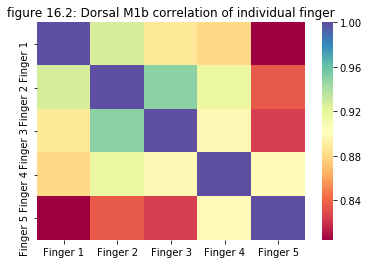

In [26]:
finger_summary('Dorsal_M1b')
plt.title('figure 16.2: Dorsal M1b correlation of individual finger')

__Dorsal S1__

          Finger 1  Finger 2  Finger 3  Finger 4  Finger 5
Finger 1  1.000000  0.874363  0.788370  0.837834  0.836436
Finger 2  0.874363  1.000000  0.909162  0.926719  0.893499
Finger 3  0.788370  0.909162  1.000000  0.923476  0.855312
Finger 4  0.837834  0.926719  0.923476  1.000000  0.887831
Finger 5  0.836436  0.893499  0.855312  0.887831  1.000000


Text(0.5, 1.0, 'figure 16.3: Dorsal S1 correlation of individual finger')

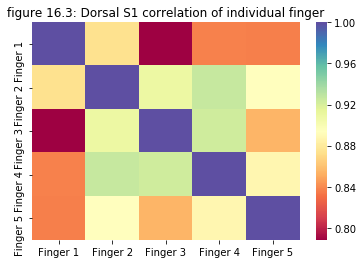

In [27]:
finger_summary('Dorsal_S1')
plt.title('figure 16.3: Dorsal S1 correlation of individual finger')

__PCA Brain ECoG Signal__

          Finger 1  Finger 2  Finger 3  Finger 4  Finger 5
Finger 1  1.000000  0.904955  0.820133  0.868957  0.875658
Finger 2  0.904955  1.000000  0.923102  0.942860  0.927448
Finger 3  0.820133  0.923102  1.000000  0.939844  0.887368
Finger 4  0.868957  0.942860  0.939844  1.000000  0.929445
Finger 5  0.875658  0.927448  0.887368  0.929445  1.000000


Text(0.5, 1.0, 'figure 16.4: PCA ECoG signal correlation of individual finger')

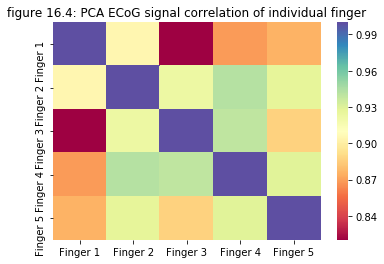

In [28]:
finger_summary('Dorsal_Total')
plt.title('figure 16.4: PCA ECoG signal correlation of individual finger')

### Observation & Analysis: 
Through observing correlation coefficient from figure 16, we found a general pattern that the closer the fingers, the higher the correlation of their corresponding brain signals. This was consistent but also novel to previous findings in Liao’s (2014) paper. Indeed, there was a specific frequency that was attributed most to individual finger movement, which was the reason why it was possible to predict finger movement from brain signals. However, we also found that the closer the fingers, the more likely that the frequencies specific to adjacent fingers were correlated, which was quite interesting. 

## Discussion & Conclusion 
We found coupling of theta phase and gamma power did exist across the movement of all five fingers. Gamma amplitude was usually larger at the trough phase of theta oscillation. However, the relationships was not as significant as the ones found in previous study conducted by Canolty and his colleagues (2006). Some possible reasons for this weaker relationship will be discussed in the following Limitation section.


The correlation between finger flexion and brain signal was different for different fingers. The correlation coefficient had small magnitude for all the fingers, which might because the brain signals can be affected by many other factors, while the flexion vector was only a small part of the factors, recorded from each finger seperately. Although the correlation was small, the discrepancy of correlation coefficient magnitude for different fingers was consistent through all three channels. This suggested there was some relatively consistent relationship between brain signals and different fingers. 

In the ECoG averaging signal plots for each finger, there was a consistent bump/increase in the ECoG signals over three channels and a decrease in PCA dimensionality reduced ECoG signal. Comparing with the 100 randomly selected onset trials which showed almost uniform signal pattern, the increase/decrease in signal magnitude in the response time-locked signal plots suggested that movement of different finger did produce different brain signals since the correlation between them was never 1. This finding was consistent with the research study conducted by Liao and his collegues (2014) that brain signals would be able to predict which finger had moved.


We also found a consistent pattern through all the channels that the closer the figners, the more correlated their brain signals were. This made us think about topography map in our brain. It might contributed to the prediction of finger movement from EEG/ECoG data. 

Overall, our research confirms our hypothesis that correlation magnitude between brain signals and finger flexion for each finger was different. Something interesting that we did not expected would be that although the correlation between brain signals during different fingers' movement was different, the differece was consistent through all channels. That was, the closer the fingers were to each other, the higher the correlation was between their brain signals. 

## Limitations
### Sensor resolution 
As we saw in the correlation matrix of the three signal channels, there was a stronger relationship between each M1 electrode (M1a & M1b) and S1 electrode. We could not know exactly what caused this stronger correlation. We had a hypothesis that this might happened because each M1 electrode was measuring responses coming from different fingers while S1 happened to measure something that correspond more to the comprehensive signal to both of those fingers; however we would never know for sure since there was no basis for our assumption. If we had finner sensors, we would be able to know which specific areas we were recording and study what those areas were responded for. This limitation on sensor resolution might also result in different strength of ECoG signals recorded from the electrodes.

### Only Three Data Channels
In the study conducted by Canolty and his colleagues (2006), they used 64 channels to record a finer measurement of ECoG signals rather the 3 channels here in our project. More channels would provide more information and more spatial resolution.



### Coupling Choice 
In our project, we only examined coupling between theta and gamma frequencies since we were not able to find what frequencies' coupling are most dominant during finger movement. On the other hand, Canolty's paper on theta phase and gamma power coupling was during language related target detection, but not finger movement. This maybe one of the potential reasons why the theta gamma coupling was not as strong as the ones we learned in the study conducted by Canolty and his colleagues (2006). As a result, while applying the filters and choosing parameters for functions, we might have locked onto parameters that were more inclined to reproduce the result of his paper. Therefore, it would be much better if we could find more previous research that were specific to finger movement frequencies coupling. Or if we had time, we should probably try more combinations of power and phase of different frequenices to see which one works the best for finger movement. That might be a potential study for future as well. 


## Reference 

Canolty, R. T., Edwards, E., Dalal, S. S., Soltani, M., Nagarajan, S. S., Kirsch, H.E., Berger, M.S., Barbaro, N. M., & Knight, R.T. (2006). High gamma power is phase-locked to theta oscillations in human neocortex. _Science, 313(5793)_, 1626-1628. 

Hoffman, B. (2011). Cognitive efficiency: A conceptual and methodological comparison. _Learning and Instruction, 22(2012)_, 133-144. 

Liang, N., & Bougrain, L. (2012). Decoding finger flexion from band-specific ECoG signals in humans. _Front Neurosci, 6(91)_, 1-6. Doi: 10.3389/fnins.2012.00091

Liao, K., Xiao, R., Gonzalez, J, Ding, Lei. Decoding Individual Finger Movements from One Hand Using Human EEG Signals. _PLOS ONE 9(1): e85192_. https://doi.org/10.1371/journal.pone.0085192

Miller, K.J., Leuthardt, E.C., Schalk, G., Rao R. P. N., Anderson, N.R., Moran, D.W., Miller, J.W., & Ojemann, J. G. (2007). Spectral changes in cortical surface potentials during motor movement. _The Journal of Neuroscience, 27(9)_, 2424-2432.

## Acknowledgement 
The data was curated by Richard Gao. 
Thank you for advice and help from instructor Richard Gao and TA Simon Niu.  

## Contribution 
We both contributed equally to this final project, including coding, presentation, analysis, and writing.  

## Apendix
Below are some of the codes that we were originally considering but did not give us conclusive result related to our research question, so we decided not to use them.  

In [29]:
# #seperate data for movement vs rest 
# reaction = human_ecog_data['stim']
# rest = np.array(np.where(reaction <=0)[0])
# movement = np.array(np.where(reaction > 0)[0])
# #area 1 movement 
# FIR_gamma_1 = signal.firwin(int(3*fs/30) -1, [30,50], fs=fs, pass_zero=False)
# gamma_osc_1_movement = np.convolve(area_1[movement], FIR_gamma_1, mode='same') 
# x_a_gamma_1_movement = signal.hilbert(gamma_osc_1_movement)
# gamma_power_1_movement, gamma_phase_1_movement = compute_power_phase(x_a_gamma_1_movement)

# FIR_theta_1 = signal.firwin(int(3*fs/4) -1, [4,10], fs=fs, pass_zero=False)
# theta_osc_1_movement = np.convolve(area_1[movement], FIR_theta_1, mode='same') 
# x_a_theta_1_movement = signal.hilbert(theta_osc_1_movement)
# theta_power_1_movement, theta_phase_1_movement = compute_power_phase(x_a_theta_1_movement)

# #area 1 rest 
# gamma_osc_1_rest = np.convolve(area_1[rest], FIR_gamma_1, mode='same') 
# x_a_gamma_1_rest = signal.hilbert(gamma_osc_1_rest)
# gamma_power_1_rest, gamma_phase_1_rest = compute_power_phase(x_a_gamma_1_rest)

# theta_osc_1_rest = np.convolve(area_1[rest], FIR_theta_1, mode='same') 
# x_a_theta_1_rest = signal.hilbert(theta_osc_1_rest)
# theta_power_1_rest, theta_phase_1_rest = compute_power_phase(x_a_theta_1_rest)

# #area 2 movement 
# FIR_gamma_2 = signal.firwin(int(3*fs/30) -1, [30,50], fs=fs, pass_zero=False)
# gamma_osc_2_movement = np.convolve(area_2[movement], FIR_gamma_2, mode='same') 
# x_a_gamma_2_movement = signal.hilbert(gamma_osc_2_movement)
# gamma_power_2_movement, gamma_phase_2_movement = compute_power_phase(x_a_gamma_2_movement)

# FIR_theta_2 = signal.firwin(int(3*fs/4) -1, [4,10], fs=fs, pass_zero=False)
# theta_osc_2_movement = np.convolve(area_2[movement], FIR_theta_2, mode='same') 
# x_a_theta_2_movement = signal.hilbert(theta_osc_2_movement)
# theta_power_2_movement, theta_phase_2_movement = compute_power_phase(x_a_theta_2_movement)

# #area 2 rest
# gamma_osc_2_rest = np.convolve(area_2[rest], FIR_gamma_2, mode='same') 
# x_a_gamma_2_rest = signal.hilbert(gamma_osc_2_rest)
# gamma_power_2_rest, gamma_phase_2_rest = compute_power_phase(x_a_gamma_2_rest)

# theta_osc_2_rest = np.convolve(area_2[rest], FIR_theta_2, mode='same')
# x_a_theta_2_rest = signal.hilbert(theta_osc_2_rest)
# theta_power_2_rest, theta_phase_2_rest = compute_power_phase(x_a_theta_2_rest)

# #area 3 movement
# FIR_gamma_3 = signal.firwin(int(3*fs/30) -1, [30,50], fs=fs, pass_zero=False)
# gamma_osc_3_movement = np.convolve(area_3[movement], FIR_gamma_3, mode='same') 
# x_a_gamma_3_movement = signal.hilbert(gamma_osc_3_movement)
# gamma_power_3_movement, gamma_phase_3_movement = compute_power_phase(x_a_gamma_3_movement)

# FIR_theta_3 = signal.firwin(int(3*fs/4) -1, [4,10], fs=fs, pass_zero=False)
# theta_osc_3_movement = np.convolve(area_3[movement], FIR_theta_3, mode='same') 
# x_a_theta_3_movement = signal.hilbert(theta_osc_3_movement)
# theta_power_3_movement, theta_phase_3_movement = compute_power_phase(x_a_theta_3_movement)

# #area 3 rest
# gamma_osc_3_rest = np.convolve(area_3[rest], FIR_gamma_3, mode='same') 
# x_a_gamma_3_rest = signal.hilbert(gamma_osc_3_rest)
# gamma_power_3_rest, gamma_phase_3_rest = compute_power_phase(x_a_gamma_3_rest)

# theta_osc_3_rest = np.convolve(area_3[rest], FIR_theta_3, mode='same') 
# x_a_theta_3_rest = signal.hilbert(theta_osc_3_rest)
# theta_power_3_rest, theta_phase_3_rest = compute_power_phase(x_a_theta_3_rest)

In [90]:

#movement rest 
# peak_inds_1_movement = np.where(np.logical_and(theta_phase_1_movement>-np.pi/2, theta_phase_1_movement<np.pi/2))[0]
# trough_inds_1_movement = np.where(np.logical_or(theta_phase_1_movement<-np.pi/2, theta_phase_1_movement>np.pi/2))[0]

# peak_inds_1_rest = np.where(np.logical_and(theta_phase_1_rest>-np.pi/2, theta_phase_1_rest<np.pi/2))[0]
# trough_inds_1_rest = np.where(np.logical_or(theta_phase_1_rest<-np.pi/2, theta_phase_1_rest>np.pi/2))[0]

# plt.figure(figsize=(15,3))

# plt.figure(figsize=(10,10))
# plt.subplot(1, 2, 1)
# plt.hist(np.abs(x_a_gamma_1_movement)[peak_inds_1_movement], 100, color='k',normed=True, histtype='step', label='Peak');
# plt.hist(np.abs(x_a_gamma_1_movement)[trough_inds_1_movement],100, color='r',normed=True, histtype='step', label='Trough');
# plt.xlabel('gamma amplitude')
# plt.ylabel('number')
# plt.title('movement')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.hist(np.abs(x_a_gamma_1_rest)[peak_inds_1_rest], 100, color='k',normed=True, histtype='step', label='Peak');
# plt.hist(np.abs(x_a_gamma_1_rest)[trough_inds_1_rest],100, color='r',normed=True, histtype='step', label='Trough');
# plt.xlabel('gamma amplitude')
# plt.ylabel('number')
# plt.title('rest')
# plt.legend()

# plt.figure(figsize=(10,10))
# plt.subplot(1, 2, 1)
# plt.plot(theta_phase_1_movement,2*np.abs(x_a_gamma_1_movement),'.');
# plt.xlabel('theta phase')
# plt.ylabel('gamma amplitude')
# plt.title('movement')
# plt.subplot(1, 2, 2)
# plt.plot(theta_phase_1_rest,2*np.abs(x_a_gamma_1_rest),'.');
# plt.xlabel('theta phase')
# plt.ylabel('gamma amplitude')
# plt.title('rest')

In [91]:
#coupling graph for area_2 
# plt.figure(figsize=(15,3))
# plt.plot(t,theta_phase_2,'.',label='theta phase')
# plt.plot(t,4*gamma_power_2,'.',label='gamma power')
# plt.xlabel('time(seconds)')
# plt.xlim(0,2)
# plt.legend()

# peak_inds_2_movement = np.where(np.logical_and(theta_phase_2_movement>-np.pi/2, theta_phase_2_movement<np.pi/2))[0]
# trough_inds_2_movement = np.where(np.logical_or(theta_phase_2_movement<-np.pi/2, theta_phase_2_movement>np.pi/2))[0]
# peak_inds_2_rest = np.where(np.logical_and(theta_phase_2_rest>-np.pi/2, theta_phase_2_rest<np.pi/2))[0]
# trough_inds_2_rest = np.where(np.logical_or(theta_phase_2_rest<-np.pi/2, theta_phase_2_rest>np.pi/2))[0]


# # plt.figure(figsize=(15,3))
# # # plot the theta peak and trough phases
# # plt.plot(t[peak_inds_2], theta_phase_2[peak_inds_2], '.',label='phase peak')
# # plt.plot(t[trough_inds_2], theta_phase_2[trough_inds_2], '.',label='phase trough')
# # # plot the gamma power corresponding to theta peak and trough phases
# # plt.plot(t[peak_inds_2], gamma_power_2[peak_inds_2]*4, '.',label='phase peak')
# # plt.plot(t[trough_inds_2], gamma_power_2[trough_inds_2]*4, '.',label='phase trough')
# # plt.xlabel('time(seconds)')
# # plt.ylabel('power')
# # plt.xlim(0,2)
# # plt.legend()

# # complete the function call to plot the histogram
# plt.figure(figsize=(10,10))
# #movement
# plt.subplot(1, 2, 1)
# plt.hist(np.abs(x_a_gamma_2_movement)[peak_inds_2_movement], 100, color='k',normed=True, histtype='step', label='Peak');
# plt.hist(np.abs(x_a_gamma_2_movement)[trough_inds_2_movement],100, color='r',normed=True, histtype='step', label='Trough');
# plt.xlabel('gamma amplitude')
# plt.ylabel('number')
# plt.title('movement')
# plt.legend()

#rest
# plt.subplot(1, 2, 2)
# plt.hist(np.abs(x_a_gamma_2_rest)[peak_inds_2_rest], 100, color='k',normed=True, histtype='step', label='Peak');
# plt.hist(np.abs(x_a_gamma_2_rest)[trough_inds_2_rest],100, color='r',normed=True, histtype='step', label='Trough');
# plt.xlabel('gamma amplitude')
# plt.ylabel('number')
# plt.title('rest')
# plt.legend()



# plt.figure(figsize=(10,10))
# #movement
# plt.subplot(1, 2, 1)
# plt.plot(theta_phase_2_movement,2*np.abs(x_a_gamma_2_movement),'.');
# plt.xlabel('theta phase')
# plt.ylabel('gamma amplitude')
# plt.title('movement')

# #rest
# plt.subplot(1, 2, 2)
# plt.plot(theta_phase_2_rest,2*np.abs(x_a_gamma_2_rest),'.');
# plt.xlabel('theta phase')
# plt.ylabel('gamma amplitude')
# plt.title('rest')


In [92]:
# peak_inds_3_movement = np.where(np.logical_and(theta_phase_3_movement>-np.pi/2, theta_phase_3_movement<np.pi/2))[0]
# trough_inds_3_movement = np.where(np.logical_or(theta_phase_3_movement<-np.pi/2, theta_phase_3_movement>np.pi/2))[0]
# peak_inds_3_rest = np.where(np.logical_and(theta_phase_3_rest>-np.pi/2, theta_phase_3_rest<np.pi/2))[0]
# trough_inds_3_rest = np.where(np.logical_or(theta_phase_3_rest<-np.pi/2, theta_phase_3_rest>np.pi/2))[0]


# plt.figure(figsize=(10,10))
# #movement
# plt.subplot(1, 2, 1) 
# plt.hist(np.abs(x_a_gamma_3_movement)[peak_inds_3_movement], 100, color='k',normed=True, histtype='step', label='Peak');
# plt.hist(np.abs(x_a_gamma_3_movement)[trough_inds_3_movement],100, color='r',normed=True, histtype='step', label='Trough');
# plt.xlabel('gamma amplitude')
# plt.ylabel('number')
# plt.legend()
# plt.title('movement')
# #rest 
# plt.subplot(1, 2, 2)
# plt.hist(np.abs(x_a_gamma_3_rest)[peak_inds_3_rest], 100, color='k',normed=True, histtype='step', label='Peak');
# plt.hist(np.abs(x_a_gamma_3_rest)[trough_inds_3_rest],100, color='r',normed=True, histtype='step', label='Trough');
# plt.xlabel('gamma amplitude')
# plt.ylabel('number')
# plt.legend()
# plt.title('rest')

# plt.figure(figsize=(20,10))
# #movement
# plt.subplot(1, 2, 1) 
# plt.plot(theta_phase_3_movement,2*np.abs(x_a_gamma_3_movement),'.');
# plt.xlabel('theta phase')
# plt.ylabel('gamma amplitude')
# plt.title('movement')

# #rest
# plt.subplot(1, 2, 2) 
# plt.plot(theta_phase_3_rest,2*np.abs(x_a_gamma_3_rest),'.');
# plt.xlabel('theta phase')
# plt.ylabel('gamma amplitude')
# plt.title('rest')
